Multi-Driver Telemetry Analysis

This notebook engineers telemetry data from the Fast-F1 API for telemetry dataframes for multiple drivers. It utilizes a structured workflow for data acquisition, preparation, and further exploration prior to applying machine learning models to multi-driver behavior analysis results. Additional descriptive statistics are added to single driver data frames that will then be concatenated and used as input for machine learning models.

NOTE: This notebook will not compile as standalone. Please pull down the project from GitHub (git clone https://github.com/yourusername/f1-driving-style-analytics-tool.git) and install the necessary dependencies. Further instruction is included in the README.md

The code below adds the parent directory to Python’s module search path and configures logging to suppress all FastF1 logs below the warning level. This will enable subsequent code blocks that use imports to work seamlessly and keep my resulting code compilations clean and easy to read.

In [1]:
import sys
import os
import logging

root = os.path.abspath("..")
sys.path.append(root)

logging.getLogger('fastf1').setLevel(logging.ERROR)

In this section, I import Python libraries for data visualization, numerical analysis, and working with Pandas dataframes that the FastF1 API is primarily structured with. I also import custom functions and modules for preprocessing F1 data and constants. To support full visibility into the datasets without truncation, I configure Pandas display options to show all rows and columns.

In [2]:
from src.data import f1_data
from src.utils import f1_constants, f1_pandas_helpers
from src.preprocessing import telemetry_cleaning, feature_engineering
from src.viz import plots

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)  # reset_option to compact dataframe view
pd.set_option('display.max_columns', None)


The following code initializes a single F1 race session by defining parameters such as year, location, and session type. These values are passed into the custom F1Session class (from f1_data.py), which creates a session object built on top of Fast-F1. This object provides access to race data as well as custom functions I’ve implemented.

The session parameters were chosen to best match Tier 1 control qualities:

- Weather: Abu Dhabi (clear, dry conditions)
- Max Speed: C5 Ultra Soft Tires
- Minimize Outliers: Qualifying Sessions (Q3 & Q2)
- Traffic: Avoid tow laps to avoid slipstream bias
- Corner Analysis → Isolates driver techniques

In [3]:
year = 2024
grand_prix = f1_constants.F1Constants.LOCATIONS["Abu Dhabi"]
session_type = f1_constants.F1Constants.SESSIONS["Q"]

session = f1_data.F1Session(year, grand_prix, session_type)

req         WARNING 	DEFAULT CACHE ENABLED! (716.91 MB) /Users/phillipsmith/Library/Caches/fastf1
core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '55', '27', '1', '10', '63', '14', '77', '11', '22', '30', '18', '16', '20', '23', '24', '44', '43', '61']


All drivers who participated in the specific location's Q2 and Q3 sessions will be analyzed and assigned variables to be identified by their three-letter name code. Q3 data will be used for each driver whenever available; otherwise, Q2 data will be selected.

Constants for telemetry data is also initialized as variables for ease of use during visualization.

In [4]:
# driver constants
norris = f1_constants.F1Constants.DRIVERS["Lando Norris"]
piastri = f1_constants.F1Constants.DRIVERS["Oscar Piastri"]
verstappen = f1_constants.F1Constants.DRIVERS["Max Verstappen"]
perez = f1_constants.F1Constants.DRIVERS["Sergio Perez"]
sainz = f1_constants.F1Constants.DRIVERS["Carlos Sainz"]
leclerc = f1_constants.F1Constants.DRIVERS["Charles Leclerc"]
bottas = f1_constants.F1Constants.DRIVERS["Valtteri Bottas"]
alonso = f1_constants.F1Constants.DRIVERS["Fernando Alonso"]
stroll = f1_constants.F1Constants.DRIVERS["Lance Stroll"]
gasly = f1_constants.F1Constants.DRIVERS["Pierre Gasly"]
hulkenberg = f1_constants.F1Constants.DRIVERS["Nico Hulkenberg"]
magnussen = f1_constants.F1Constants.DRIVERS["Kevin Magnussen"]
lawson = f1_constants.F1Constants.DRIVERS["Liam Lawson"]
tsunoda = f1_constants.F1Constants.DRIVERS["Yuki Tsunoda"]
russell = f1_constants.F1Constants.DRIVERS["George Russell"]

# telemetry constants
speed = f1_constants.F1Constants.TELEMETRY_COLUMNS["Speed (m/s)"]
acceleration = f1_constants.F1Constants.TELEMETRY_COLUMNS["Acceleration (m/s²)"]
jerk = f1_constants.F1Constants.TELEMETRY_COLUMNS["Jerk (m/s³)"]
rpm = f1_constants.F1Constants.TELEMETRY_COLUMNS["RPM"]
g_force = f1_constants.F1Constants.TELEMETRY_COLUMNS["G-force (g)"]
gear = f1_constants.F1Constants.TELEMETRY_COLUMNS["nGear"]
throttle = f1_constants.F1Constants.TELEMETRY_COLUMNS["Throttle (%)"]
brakes = f1_constants.F1Constants.TELEMETRY_COLUMNS["BrakesApplied"]
steering = f1_constants.F1Constants.TELEMETRY_COLUMNS["Steering Wheel Angle (°)"]

The code extracts circuit information for the session’s corners. The `critical_turn` array identifies corners where driver behavior is especially important for sector and overall lap performance. Adjusting the `radius` value controls how much telemetry around each turn is included, allowing you to visualize throttle and braking traces at the desired level of detail.

In [5]:
corner_position = session.get_circuit_info().corners
corner_position_cleaned = telemetry_cleaning.clean_circuit_corner_data(corner_position)

# 16 --> 2500, 12 --> 1800
critical_turn = [16]
radius = 2500

For each driver, the telemetry from their fastest qualifying lap is isolated by filtering based on sector timestamps. These sector datasets are then cleaned, enriched with derived features, and filtered by turn to focus on the segments most informative for analyzing driver behavior and responses in complex areas.

Q3 data for Lando Norris, McLaren

In [6]:
q1, q2, q3 = session.get_laps(norris).split_qualifying_sessions()
norris_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

norris_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(norris_q3_telemetry, start=sector_1_start, end=sector_1_end)
norris_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(norris_sector1_telemetry, norris)

norris_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(norris_q3_telemetry, start=sector_1_end, end=sector_2_end)
norris_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(norris_sector2_telemetry, norris)

norris_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(norris_q3_telemetry, start=sector_2_end, end=sector_3_end)
norris_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(norris_sector3_telemetry, norris)

norris_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(norris_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

norris_sector3_telemetry_features = feature_engineering.TelemetryFeatures(norris_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().steering_wheel_angle().get_features_df()

norris_sector3_telemetry_features

,DriverCode,SessionTime (s),SectorTime (s),RPM,Speed (m/s),Acceleration (m/s²),Jerk (m/s³),G-force (g),nGear,Throttle (%),BrakesApplied,Distance (m),X (1/10 m),Y (1/10 m),Z (1/10 m),Steering Wheel Angle (°)
8558,NOR,0 days 01:18:13.993000,0.000,11788.536190,71.510864,3.463562,-3.287628e+01,0.353185,6,100.000000,0,25719.691919,299.000000,-260.000000,-227.000000,-0.000000
8559,NOR,0 days 01:18:14.038000,0.045,11813.000000,71.666724,1.984129,-1.430736e-05,0.202325,6,100.000000,0,25722.935556,271.637451,-261.959337,-226.446575,0.000000
8560,NOR,0 days 01:18:14.273000,0.280,10724.446132,72.132994,1.984126,-1.837150e+01,0.202325,6,100.000000,0,25739.903240,106.000000,-252.000000,-223.000000,-788.524684
8561,NOR,0 days 01:18:14.318000,0.325,10516.000000,72.222280,1.157408,-8.036501e-13,0.118023,6,100.000000,0,25743.157778,59.851033,-241.062621,-222.323425,162.402971
8562,NOR,0 days 01:18:14.494000,0.501,10545.333333,72.425984,1.157408,1.808452e+01,0.118023,6,100.000000,0,25755.906132,-131.000000,-183.000000,-220.000000,15.198907
8563,NOR,0 days 01:18:14.558000,0.565,10556.000000,72.500058,2.314817,-1.287663e-04,0.236046,7,100.000000,0,25760.557778,-173.796843,-167.953880,-219.507971,28.489059
8564,NOR,0 days 01:18:14.793000,0.800,10613.770849,73.044040,2.314787,-2.314757e+02,0.236043,7,100.000000,0,25777.724782,-249.000000,-127.000000,-219.000000,28.935783
8565,NOR,0 days 01:18:14.798000,0.805,10615.000000,73.055614,1.157408,-9.645069e+00,0.118023,7,100.000000,0,25778.091111,-251.103065,-125.688249,-218.996705,452.767402
8566,NOR,0 days 01:18:15.038000,1.045,10583.000000,73.333392,-1.157408,-5.157911e-13,0.118023,7,100.000000,0,25795.691111,-395.695753,-27.324701,-219.006689,6.975426
8567,NOR,0 days 01:18:15.134000,1.141,10587.800000,73.222281,-1.157408,2.411267e+01,0.118023,7,100.000000,0,25802.704040,-468.000000,51.000000,-219.000000,99.892263


The following code blocks generate new descriptive statistical features to be used as inputs for the clustering model.

In [7]:
norris_brake_engage = (norris_sector3_telemetry_features['BrakesApplied'] == 1) & (norris_sector3_telemetry_features['BrakesApplied'].shift() == 0)
norris_initial_brake_timestamp = norris_sector3_telemetry_features.loc[norris_brake_engage, 'SectorTime (s)'].min()
norris_brake_disengage = (norris_sector3_telemetry_features['BrakesApplied'] == 0) & (norris_sector3_telemetry_features['BrakesApplied'].shift() == 1)
norris_max_brake_duration = (norris_sector3_telemetry_features.loc[norris_brake_disengage, 'SectorTime (s)'].min()) - norris_initial_brake_timestamp

norris_throttle_reengage = (norris_sector3_telemetry_features['Throttle (%)'] > 0) & (norris_sector3_telemetry_features['Throttle (%)'].shift() == 0)
norris_throttle_ramp_initial = norris_sector3_telemetry_features.loc[norris_throttle_reengage, 'SectorTime (s)'].min()
norris_throttle_max = (norris_sector3_telemetry_features['Throttle (%)'] >= 99) & (norris_sector3_telemetry_features['Throttle (%)'].shift() < 99)
norris_throttle_ramp_final = (norris_sector3_telemetry_features.loc[norris_throttle_max, 'SectorTime (s)'].min())
norris_throttle_ramp_time = norris_throttle_ramp_final - norris_throttle_ramp_initial

norris_speed_ramp_final = (norris_sector3_telemetry_features.loc[norris_throttle_max, 'Speed (m/s)'].min())
norris_exit_speed_max = (norris_sector3_telemetry_features['Speed (m/s)']).iloc[-1]
norris_speed_minimum = (norris_sector3_telemetry_features['Speed (m/s)']).min()

norris_speed_min_timestamp = norris_sector3_telemetry_features.loc[norris_sector3_telemetry_features['Speed (m/s)'] == norris_speed_minimum, 'SectorTime (s)'].values[0]
norris_exit_speed_max_timestamp = (norris_sector3_telemetry_features['SectorTime (s)']).iloc[-1]
norris_exit_accel_duration = norris_exit_speed_max_timestamp - norris_speed_min_timestamp

Descriptive Statistics — Lando Norris - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [8]:
norris_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(norris_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
norris_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(norris, norris_turn_dfs, norris_initial_brake_timestamp, norris_max_brake_duration, norris_throttle_ramp_initial, 
                                                                     norris_throttle_ramp_time, norris_speed_ramp_final, norris_exit_speed_max, norris_speed_minimum, norris_exit_accel_duration)

norris_eda_summary

,Driver,Turn,Row Count,Brake Initial,Brake Duration,Throttle Ramp Initial,Throttle Ramp Time,Speed Ramp Final,Exit Speed Max,Speed Minimum,Exit Accel Duration,Max Gs,Mean Gs,Gear Shifts,Throttle Events,Brake Events
0,NOR,16,63,2.485,1.799,4.401,1.483,45.277814,63.611162,38.333364,3.161,4.602889,0.878407,4,2,1


Q3 data for Oscar Piastri, McLaren

In [9]:
q1, q2, q3 = session.get_laps(piastri).split_qualifying_sessions()
piastri_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

piastri_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(piastri_q3_telemetry, start=sector_1_start, end=sector_1_end)
piastri_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(piastri_sector1_telemetry, piastri)

piastri_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(piastri_q3_telemetry, start=sector_1_end, end=sector_2_end)
piastri_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(piastri_sector2_telemetry, piastri)

piastri_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(piastri_q3_telemetry, start=sector_2_end, end=sector_3_end)
piastri_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(piastri_sector3_telemetry, piastri)

piastri_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(piastri_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

piastri_sector3_telemetry_features = feature_engineering.TelemetryFeatures(piastri_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().steering_wheel_angle().get_features_df()


The following code blocks generate new descriptive statistical features to be used as inputs for the clustering model.

In [10]:
piastri_brake_engage = (piastri_sector3_telemetry_features['BrakesApplied'] == 1) & (piastri_sector3_telemetry_features['BrakesApplied'].shift() == 0)
piastri_initial_brake_timestamp = piastri_sector3_telemetry_features.loc[piastri_brake_engage, 'SectorTime (s)'].min()
piastri_brake_disengage = (piastri_sector3_telemetry_features['BrakesApplied'] == 0) & (piastri_sector3_telemetry_features['BrakesApplied'].shift() == 1)
piastri_max_brake_duration = (piastri_sector3_telemetry_features.loc[piastri_brake_disengage, 'SectorTime (s)'].min()) - piastri_initial_brake_timestamp

piastri_throttle_reengage = (piastri_sector3_telemetry_features['Throttle (%)'] > 0) & (piastri_sector3_telemetry_features['Throttle (%)'].shift() == 0)
piastri_throttle_ramp_initial = piastri_sector3_telemetry_features.loc[piastri_throttle_reengage, 'SectorTime (s)'].min()
piastri_throttle_max = (piastri_sector3_telemetry_features['Throttle (%)'] >= 99) & (piastri_sector3_telemetry_features['Throttle (%)'].shift() < 99)
piastri_throttle_ramp_final = (piastri_sector3_telemetry_features.loc[piastri_throttle_max, 'SectorTime (s)'].min())
piastri_throttle_ramp_time = piastri_throttle_ramp_final - piastri_throttle_ramp_initial

piastri_speed_ramp_final = (piastri_sector3_telemetry_features.loc[piastri_throttle_max, 'Speed (m/s)'].min())
piastri_exit_speed_max = (piastri_sector3_telemetry_features['Speed (m/s)']).iloc[-1]
piastri_speed_minimum = (piastri_sector3_telemetry_features['Speed (m/s)']).min()

piastri_speed_min_timestamp = piastri_sector3_telemetry_features.loc[piastri_sector3_telemetry_features['Speed (m/s)'] == piastri_speed_minimum, 'SectorTime (s)'].values[0]
piastri_exit_speed_max_timestamp = (piastri_sector3_telemetry_features['SectorTime (s)']).iloc[-1]
piastri_exit_accel_duration = piastri_exit_speed_max_timestamp - piastri_speed_min_timestamp

Descriptive Statistics - Oscar Piastri - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [11]:
piastri_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(piastri_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
piastri_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(piastri, piastri_turn_dfs, piastri_initial_brake_timestamp, piastri_max_brake_duration, piastri_throttle_ramp_initial, 
                                                                      piastri_throttle_ramp_time, piastri_speed_ramp_final, piastri_exit_speed_max, piastri_speed_minimum, piastri_exit_accel_duration)

piastri_eda_summary

,Driver,Turn,Row Count,Brake Initial,Brake Duration,Throttle Ramp Initial,Throttle Ramp Time,Speed Ramp Final,Exit Speed Max,Speed Minimum,Exit Accel Duration,Max Gs,Mean Gs,Gear Shifts,Throttle Events,Brake Events
0,PIA,16,67,2.724,1.2,4.402,1.563,43.888924,64.166718,37.777808,3.161,3.068595,0.850449,5,2,1


Q3 data for Max Verstappen, Red Bull

In [12]:
q1, q2, q3 = session.get_laps(verstappen).split_qualifying_sessions()
verstappen_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

verstappen_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(verstappen_q3_telemetry, start=sector_1_start, end=sector_1_end)
verstappen_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(verstappen_sector1_telemetry, verstappen)

verstappen_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(verstappen_q3_telemetry, start=sector_1_end, end=sector_2_end)
verstappen_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(verstappen_sector2_telemetry, verstappen)

verstappen_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(verstappen_q3_telemetry, start=sector_2_end, end=sector_3_end)
verstappen_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(verstappen_sector3_telemetry, verstappen)

verstappen_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(verstappen_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

verstappen_sector3_telemetry_features = feature_engineering.TelemetryFeatures(verstappen_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().steering_wheel_angle().get_features_df()


The following code blocks generate new descriptive statistical features to be used as inputs for the clustering model.

In [13]:
verstappen_brake_engage = (verstappen_sector3_telemetry_features['BrakesApplied'] == 1) & (verstappen_sector3_telemetry_features['BrakesApplied'].shift() == 0)
verstappen_initial_brake_timestamp = verstappen_sector3_telemetry_features.loc[verstappen_brake_engage, 'SectorTime (s)'].min()
verstappen_brake_disengage = (verstappen_sector3_telemetry_features['BrakesApplied'] == 0) & (verstappen_sector3_telemetry_features['BrakesApplied'].shift() == 1)
verstappen_max_brake_duration = (verstappen_sector3_telemetry_features.loc[verstappen_brake_disengage, 'SectorTime (s)'].min()) - verstappen_initial_brake_timestamp

verstappen_throttle_reengage = (verstappen_sector3_telemetry_features['Throttle (%)'] > 0) & (verstappen_sector3_telemetry_features['Throttle (%)'].shift() == 0)
verstappen_throttle_ramp_initial = verstappen_sector3_telemetry_features.loc[verstappen_throttle_reengage, 'SectorTime (s)'].min()
verstappen_throttle_max = (verstappen_sector3_telemetry_features['Throttle (%)'] >= 99) & (verstappen_sector3_telemetry_features['Throttle (%)'].shift() < 99)
verstappen_throttle_ramp_final = (verstappen_sector3_telemetry_features.loc[verstappen_throttle_max, 'SectorTime (s)'].min())
verstappen_throttle_ramp_time = verstappen_throttle_ramp_final - verstappen_throttle_ramp_initial

verstappen_speed_ramp_final = (verstappen_sector3_telemetry_features.loc[verstappen_throttle_max, 'Speed (m/s)'].min())
verstappen_exit_speed_max = (verstappen_sector3_telemetry_features['Speed (m/s)']).iloc[-1]
verstappen_speed_minimum = (verstappen_sector3_telemetry_features['Speed (m/s)']).min()

verstappen_speed_min_timestamp = verstappen_sector3_telemetry_features.loc[verstappen_sector3_telemetry_features['Speed (m/s)'] == verstappen_speed_minimum, 'SectorTime (s)'].values[0]
verstappen_exit_speed_max_timestamp = (verstappen_sector3_telemetry_features['SectorTime (s)']).iloc[-1]
verstappen_exit_accel_duration = verstappen_exit_speed_max_timestamp - verstappen_speed_min_timestamp

Descriptive Statistics - Max Verstappen - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [14]:
verstappen_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(verstappen_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
verstappen_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(verstappen, verstappen_turn_dfs, verstappen_initial_brake_timestamp, verstappen_max_brake_duration, verstappen_throttle_ramp_initial, 
                                                                         verstappen_throttle_ramp_time, verstappen_speed_ramp_final, verstappen_exit_speed_max, verstappen_speed_minimum, verstappen_exit_accel_duration)

verstappen_eda_summary

,Driver,Turn,Row Count,Brake Initial,Brake Duration,Throttle Ramp Initial,Throttle Ramp Time,Speed Ramp Final,Exit Speed Max,Speed Minimum,Exit Accel Duration,Max Gs,Mean Gs,Gear Shifts,Throttle Events,Brake Events
0,VER,16,62,2.882,1.44,4.321,1.321,41.388922,58.888936,36.388918,3.36,3.934345,0.791087,4,2,1


Q3 data for Sergio Perez, Red Bull

In [15]:
q1, q2, q3 = session.get_laps(perez).split_qualifying_sessions()
perez_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

perez_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(perez_q3_telemetry, start=sector_1_start, end=sector_1_end)
perez_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(perez_sector1_telemetry, perez)

perez_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(perez_q3_telemetry, start=sector_1_end, end=sector_2_end)
perez_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(perez_sector2_telemetry, perez)

perez_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(perez_q3_telemetry, start=sector_2_end, end=sector_3_end)
perez_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(perez_sector3_telemetry, perez)

perez_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(perez_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

perez_sector3_telemetry_features = feature_engineering.TelemetryFeatures(perez_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().steering_wheel_angle().get_features_df()


The following code blocks generate new descriptive statistical features to be used as inputs for the clustering model.

In [16]:
perez_brake_engage = (perez_sector3_telemetry_features['BrakesApplied'] == 1) & (perez_sector3_telemetry_features['BrakesApplied'].shift() == 0)
perez_initial_brake_timestamp = perez_sector3_telemetry_features.loc[perez_brake_engage, 'SectorTime (s)'].min()
perez_brake_disengage = (perez_sector3_telemetry_features['BrakesApplied'] == 0) & (perez_sector3_telemetry_features['BrakesApplied'].shift() == 1)
perez_max_brake_duration = (perez_sector3_telemetry_features.loc[perez_brake_disengage, 'SectorTime (s)'].min()) - perez_initial_brake_timestamp

perez_throttle_reengage = (perez_sector3_telemetry_features['Throttle (%)'] > 0) & (perez_sector3_telemetry_features['Throttle (%)'].shift() == 0)
perez_throttle_ramp_initial = perez_sector3_telemetry_features.loc[perez_throttle_reengage, 'SectorTime (s)'].min()
perez_throttle_max = (perez_sector3_telemetry_features['Throttle (%)'] >= 99) & (perez_sector3_telemetry_features['Throttle (%)'].shift() < 99)
perez_throttle_ramp_final = (perez_sector3_telemetry_features.loc[perez_throttle_max, 'SectorTime (s)'].min())
perez_throttle_ramp_time = perez_throttle_ramp_final - perez_throttle_ramp_initial

perez_speed_ramp_final = (perez_sector3_telemetry_features.loc[perez_throttle_max, 'Speed (m/s)'].min())
perez_exit_speed_max = (perez_sector3_telemetry_features['Speed (m/s)']).iloc[-1]
perez_speed_minimum = (perez_sector3_telemetry_features['Speed (m/s)']).min()

perez_speed_min_timestamp = perez_sector3_telemetry_features.loc[perez_sector3_telemetry_features['Speed (m/s)'] == perez_speed_minimum, 'SectorTime (s)'].values[0]
perez_exit_speed_max_timestamp = (perez_sector3_telemetry_features['SectorTime (s)']).iloc[-1]
perez_exit_accel_duration = perez_exit_speed_max_timestamp - perez_speed_min_timestamp


Descriptive Statistics - Sergio Perez - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [17]:
perez_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(perez_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
perez_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(perez, perez_turn_dfs, perez_initial_brake_timestamp, perez_max_brake_duration, perez_throttle_ramp_initial, 
                                                                    perez_throttle_ramp_time, perez_speed_ramp_final, perez_exit_speed_max, perez_speed_minimum, perez_exit_accel_duration)

perez_eda_summary

,Driver,Turn,Row Count,Brake Initial,Brake Duration,Throttle Ramp Initial,Throttle Ramp Time,Speed Ramp Final,Exit Speed Max,Speed Minimum,Exit Accel Duration,Max Gs,Mean Gs,Gear Shifts,Throttle Events,Brake Events
0,PER,16,64,2.783,1.801,4.08,1.943,44.166702,64.444496,35.277806,3.279,3.717724,0.988737,3,2,1


Q3 data for Carlos Sainz, Ferrari

In [18]:
q1, q2, q3 = session.get_laps(sainz).split_qualifying_sessions()
sainz_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

sainz_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(sainz_q3_telemetry, start=sector_1_start, end=sector_1_end)
sainz_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(sainz_sector1_telemetry, sainz)

sainz_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(sainz_q3_telemetry, start=sector_1_end, end=sector_2_end)
sainz_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(sainz_sector2_telemetry, sainz)

sainz_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(sainz_q3_telemetry, start=sector_2_end, end=sector_3_end)
sainz_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(sainz_sector3_telemetry, sainz)

sainz_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(sainz_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

sainz_sector3_telemetry_features = feature_engineering.TelemetryFeatures(sainz_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().steering_wheel_angle().get_features_df()


The following code blocks generate new descriptive statistical features to be used as inputs for the clustering model.

In [19]:
sainz_brake_engage = (sainz_sector3_telemetry_features['BrakesApplied'] == 1) & (sainz_sector3_telemetry_features['BrakesApplied'].shift() == 0)
sainz_initial_brake_timestamp = sainz_sector3_telemetry_features.loc[sainz_brake_engage, 'SectorTime (s)'].min()
sainz_brake_disengage = (sainz_sector3_telemetry_features['BrakesApplied'] == 0) & (sainz_sector3_telemetry_features['BrakesApplied'].shift() == 1)
sainz_max_brake_duration = (sainz_sector3_telemetry_features.loc[sainz_brake_disengage, 'SectorTime (s)'].min()) - sainz_initial_brake_timestamp

sainz_throttle_reengage = (sainz_sector3_telemetry_features['Throttle (%)'] > 0) & (sainz_sector3_telemetry_features['Throttle (%)'].shift() == 0)
sainz_throttle_ramp_initial = sainz_sector3_telemetry_features.loc[sainz_throttle_reengage, 'SectorTime (s)'].min()
sainz_throttle_max = (sainz_sector3_telemetry_features['Throttle (%)'] >= 99) & (sainz_sector3_telemetry_features['Throttle (%)'].shift() < 99)
sainz_throttle_ramp_final = (sainz_sector3_telemetry_features.loc[sainz_throttle_max, 'SectorTime (s)'].min())
sainz_throttle_ramp_time = sainz_throttle_ramp_final - sainz_throttle_ramp_initial

sainz_speed_ramp_final = (sainz_sector3_telemetry_features.loc[sainz_throttle_max, 'Speed (m/s)'].min())
sainz_exit_speed_max = (sainz_sector3_telemetry_features['Speed (m/s)']).iloc[-1]
sainz_speed_minimum = (sainz_sector3_telemetry_features['Speed (m/s)']).min()

sainz_speed_min_timestamp = sainz_sector3_telemetry_features.loc[sainz_sector3_telemetry_features['Speed (m/s)'] == sainz_speed_minimum, 'SectorTime (s)'].values[0]
sainz_exit_speed_max_timestamp = (sainz_sector3_telemetry_features['SectorTime (s)']).iloc[-1]
sainz_exit_accel_duration = sainz_exit_speed_max_timestamp - sainz_speed_min_timestamp


Descriptive Statistics - Carlos Sainz - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [20]:
sainz_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(sainz_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
sainz_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(sainz, sainz_turn_dfs, sainz_initial_brake_timestamp, sainz_max_brake_duration, sainz_throttle_ramp_initial, 
                                                                    sainz_throttle_ramp_time, sainz_speed_ramp_final, sainz_exit_speed_max, sainz_speed_minimum, sainz_exit_accel_duration)

sainz_eda_summary

,Driver,Turn,Row Count,Brake Initial,Brake Duration,Throttle Ramp Initial,Throttle Ramp Time,Speed Ramp Final,Exit Speed Max,Speed Minimum,Exit Accel Duration,Max Gs,Mean Gs,Gear Shifts,Throttle Events,Brake Events
0,SAI,16,64,2.76,1.839,4.616,1.143,40.833366,64.490792,36.666696,3.217,3.540684,0.848876,4,2,1


Q2 data for Charles Leclerc, Ferrari

In [21]:
q1, q2, q3 = session.get_laps(leclerc).split_qualifying_sessions()
leclerc_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

leclerc_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(leclerc_q2_telemetry, start=sector_1_start, end=sector_1_end)
leclerc_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(leclerc_sector1_telemetry, leclerc)

leclerc_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(leclerc_q2_telemetry, start=sector_1_end, end=sector_2_end)
leclerc_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(leclerc_sector2_telemetry, leclerc)

leclerc_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(leclerc_q2_telemetry, start=sector_2_end, end=sector_3_end)
leclerc_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(leclerc_sector3_telemetry, leclerc)

leclerc_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(leclerc_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

leclerc_sector3_telemetry_features = feature_engineering.TelemetryFeatures(leclerc_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().steering_wheel_angle().get_features_df()


The following code blocks generate new descriptive statistical features to be used as inputs for the clustering model.

In [22]:
leclerc_brake_engage = (leclerc_sector3_telemetry_features['BrakesApplied'] == 1) & (leclerc_sector3_telemetry_features['BrakesApplied'].shift() == 0)
leclerc_initial_brake_timestamp = leclerc_sector3_telemetry_features.loc[leclerc_brake_engage, 'SectorTime (s)'].min()
leclerc_brake_disengage = (leclerc_sector3_telemetry_features['BrakesApplied'] == 0) & (leclerc_sector3_telemetry_features['BrakesApplied'].shift() == 1)
leclerc_max_brake_duration = (leclerc_sector3_telemetry_features.loc[leclerc_brake_disengage, 'SectorTime (s)'].min()) - leclerc_initial_brake_timestamp

leclerc_throttle_reengage = (leclerc_sector3_telemetry_features['Throttle (%)'] > 0) & (leclerc_sector3_telemetry_features['Throttle (%)'].shift() == 0)
leclerc_throttle_ramp_initial = leclerc_sector3_telemetry_features.loc[leclerc_throttle_reengage, 'SectorTime (s)'].min()
leclerc_throttle_max = (leclerc_sector3_telemetry_features['Throttle (%)'] >= 99) & (leclerc_sector3_telemetry_features['Throttle (%)'].shift() < 99)
leclerc_throttle_ramp_final = (leclerc_sector3_telemetry_features.loc[leclerc_throttle_max, 'SectorTime (s)'].min())
leclerc_throttle_ramp_time = leclerc_throttle_ramp_final - leclerc_throttle_ramp_initial

leclerc_speed_ramp_final = (leclerc_sector3_telemetry_features.loc[leclerc_throttle_max, 'Speed (m/s)'].min())
leclerc_exit_speed_max = (leclerc_sector3_telemetry_features['Speed (m/s)']).iloc[-1]
leclerc_speed_minimum = (leclerc_sector3_telemetry_features['Speed (m/s)']).min()

leclerc_speed_min_timestamp = leclerc_sector3_telemetry_features.loc[leclerc_sector3_telemetry_features['Speed (m/s)'] == leclerc_speed_minimum, 'SectorTime (s)'].values[0]
leclerc_exit_speed_max_timestamp = (leclerc_sector3_telemetry_features['SectorTime (s)']).iloc[-1]
leclerc_exit_accel_duration = leclerc_exit_speed_max_timestamp - leclerc_speed_min_timestamp


Descriptive Statistics - Charles Leclerc - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [23]:
leclerc_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(leclerc_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
leclerc_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(leclerc, leclerc_turn_dfs, leclerc_initial_brake_timestamp, leclerc_max_brake_duration, leclerc_throttle_ramp_initial, 
                                                                      leclerc_throttle_ramp_time, leclerc_speed_ramp_final, leclerc_exit_speed_max, leclerc_speed_minimum, leclerc_exit_accel_duration)

leclerc_eda_summary

,Driver,Turn,Row Count,Brake Initial,Brake Duration,Throttle Ramp Initial,Throttle Ramp Time,Speed Ramp Final,Exit Speed Max,Speed Minimum,Exit Accel Duration,Max Gs,Mean Gs,Gear Shifts,Throttle Events,Brake Events
0,LEC,16,63,2.599,1.4,NaN,NaN,43.333368,64.166718,38.333364,3.281,5.979823,0.820361,5,1,1


Q3 data for Valtteri Bottas, Alfa Romeo

In [24]:
q1, q2, q3 = session.get_laps(bottas).split_qualifying_sessions()
bottas_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

bottas_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(bottas_q3_telemetry, start=sector_1_start, end=sector_1_end)
bottas_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(bottas_sector1_telemetry, bottas)

bottas_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(bottas_q3_telemetry, start=sector_1_end, end=sector_2_end)
bottas_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(bottas_sector2_telemetry, bottas)

bottas_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(bottas_q3_telemetry, start=sector_2_end, end=sector_3_end)
bottas_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(bottas_sector3_telemetry, bottas)

bottas_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(bottas_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

bottas_sector3_telemetry_features = feature_engineering.TelemetryFeatures(bottas_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().steering_wheel_angle().get_features_df()


The following code blocks generate new descriptive statistical features to be used as inputs for the clustering model.

In [25]:
bottas_brake_engage = (bottas_sector3_telemetry_features['BrakesApplied'] == 1) & (bottas_sector3_telemetry_features['BrakesApplied'].shift() == 0)
bottas_initial_brake_timestamp = bottas_sector3_telemetry_features.loc[bottas_brake_engage, 'SectorTime (s)'].min()
bottas_brake_disengage = (bottas_sector3_telemetry_features['BrakesApplied'] == 0) & (bottas_sector3_telemetry_features['BrakesApplied'].shift() == 1)
bottas_max_brake_duration = (bottas_sector3_telemetry_features.loc[bottas_brake_disengage, 'SectorTime (s)'].min()) - bottas_initial_brake_timestamp

bottas_throttle_reengage = (bottas_sector3_telemetry_features['Throttle (%)'] > 0) & (bottas_sector3_telemetry_features['Throttle (%)'].shift() == 0)
bottas_throttle_ramp_initial = bottas_sector3_telemetry_features.loc[bottas_throttle_reengage, 'SectorTime (s)'].min()
bottas_throttle_max = (bottas_sector3_telemetry_features['Throttle (%)'] >= 99) & (bottas_sector3_telemetry_features['Throttle (%)'].shift() < 99)
bottas_throttle_ramp_final = (bottas_sector3_telemetry_features.loc[bottas_throttle_max, 'SectorTime (s)'].min())
bottas_throttle_ramp_time = bottas_throttle_ramp_final - bottas_throttle_ramp_initial

bottas_speed_ramp_final = (bottas_sector3_telemetry_features.loc[bottas_throttle_max, 'Speed (m/s)'].min())
bottas_exit_speed_max = (bottas_sector3_telemetry_features['Speed (m/s)']).iloc[-1]
bottas_speed_minimum = (bottas_sector3_telemetry_features['Speed (m/s)']).min()

bottas_speed_min_timestamp = bottas_sector3_telemetry_features.loc[bottas_sector3_telemetry_features['Speed (m/s)'] == bottas_speed_minimum, 'SectorTime (s)'].values[0]
bottas_exit_speed_max_timestamp = (bottas_sector3_telemetry_features['SectorTime (s)']).iloc[-1]
bottas_exit_accel_duration = bottas_exit_speed_max_timestamp - bottas_speed_min_timestamp


Descriptive Statistics - Valtteri Bottas - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [26]:
bottas_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(bottas_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
bottas_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(bottas, bottas_turn_dfs, bottas_initial_brake_timestamp, bottas_max_brake_duration, bottas_throttle_ramp_initial, 
                                                                     bottas_throttle_ramp_time, bottas_speed_ramp_final, bottas_exit_speed_max, bottas_speed_minimum, bottas_exit_accel_duration)

bottas_eda_summary

,Driver,Turn,Row Count,Brake Initial,Brake Duration,Throttle Ramp Initial,Throttle Ramp Time,Speed Ramp Final,Exit Speed Max,Speed Minimum,Exit Accel Duration,Max Gs,Mean Gs,Gear Shifts,Throttle Events,Brake Events
0,BOT,16,65,2.804,1.76,4.764,1.16,44.44448,64.888941,36.666696,3.377,4.868446,0.879529,4,2,1


Q3 data for Fernando Alonso, Aston Martin

In [27]:
q1, q2, q3 = session.get_laps(alonso).split_qualifying_sessions()
alonso_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

alonso_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(alonso_q3_telemetry, start=sector_1_start, end=sector_1_end)
alonso_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(alonso_sector1_telemetry, alonso)

alonso_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(alonso_q3_telemetry, start=sector_1_end, end=sector_2_end)
alonso_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(alonso_sector2_telemetry, alonso)

alonso_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(alonso_q3_telemetry, start=sector_2_end, end=sector_3_end)
alonso_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(alonso_sector3_telemetry, alonso)

alonso_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(alonso_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

alonso_sector3_telemetry_features = feature_engineering.TelemetryFeatures(alonso_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().steering_wheel_angle().get_features_df()


The following code blocks generate new descriptive statistical features to be used as inputs for the clustering model.

In [28]:
alonso_brake_engage = (alonso_sector3_telemetry_features['BrakesApplied'] == 1) & (alonso_sector3_telemetry_features['BrakesApplied'].shift() == 0)
alonso_initial_brake_timestamp = alonso_sector3_telemetry_features.loc[alonso_brake_engage, 'SectorTime (s)'].min()
alonso_brake_disengage = (alonso_sector3_telemetry_features['BrakesApplied'] == 0) & (alonso_sector3_telemetry_features['BrakesApplied'].shift() == 1)
alonso_max_brake_duration = (alonso_sector3_telemetry_features.loc[alonso_brake_disengage, 'SectorTime (s)'].min()) - alonso_initial_brake_timestamp

alonso_throttle_reengage = (alonso_sector3_telemetry_features['Throttle (%)'] > 0) & (alonso_sector3_telemetry_features['Throttle (%)'].shift() == 0)
alonso_throttle_ramp_initial = alonso_sector3_telemetry_features.loc[alonso_throttle_reengage, 'SectorTime (s)'].min()
alonso_throttle_max = (alonso_sector3_telemetry_features['Throttle (%)'] >= 99) & (alonso_sector3_telemetry_features['Throttle (%)'].shift() < 99)
alonso_throttle_ramp_final = (alonso_sector3_telemetry_features.loc[alonso_throttle_max, 'SectorTime (s)'].min())
alonso_throttle_ramp_time = alonso_throttle_ramp_final - alonso_throttle_ramp_initial

alonso_speed_ramp_final = (alonso_sector3_telemetry_features.loc[alonso_throttle_max, 'Speed (m/s)'].min())
alonso_exit_speed_max = (alonso_sector3_telemetry_features['Speed (m/s)']).iloc[-1]
alonso_speed_minimum = (alonso_sector3_telemetry_features['Speed (m/s)']).min()

alonso_speed_min_timestamp = alonso_sector3_telemetry_features.loc[alonso_sector3_telemetry_features['Speed (m/s)'] == alonso_speed_minimum, 'SectorTime (s)'].values[0]
alonso_exit_speed_max_timestamp = (alonso_sector3_telemetry_features['SectorTime (s)']).iloc[-1]
alonso_exit_accel_duration = alonso_exit_speed_max_timestamp - alonso_speed_min_timestamp


Descriptive Statistics - Fernando Alonso - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [29]:
alonso_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(alonso_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
alonso_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(alonso, alonso_turn_dfs, alonso_initial_brake_timestamp, alonso_max_brake_duration, alonso_throttle_ramp_initial, 
                                                                     alonso_throttle_ramp_time, alonso_speed_ramp_final, alonso_exit_speed_max, alonso_speed_minimum, alonso_exit_accel_duration)

alonso_eda_summary

,Driver,Turn,Row Count,Brake Initial,Brake Duration,Throttle Ramp Initial,Throttle Ramp Time,Speed Ramp Final,Exit Speed Max,Speed Minimum,Exit Accel Duration,Max Gs,Mean Gs,Gear Shifts,Throttle Events,Brake Events
0,ALO,16,63,2.721,1.479,4.04,1.84,44.166702,64.875052,36.666696,3.357,3.806235,0.922534,6,3,1


Q2 data for Lance Stroll, Aston Martin

In [30]:
q1, q2, q3 = session.get_laps(stroll).split_qualifying_sessions()
stroll_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

stroll_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(stroll_q2_telemetry, start=sector_1_start, end=sector_1_end)
stroll_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(stroll_sector1_telemetry, stroll)

stroll_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(stroll_q2_telemetry, start=sector_1_end, end=sector_2_end)
stroll_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(stroll_sector2_telemetry, stroll)

stroll_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(stroll_q2_telemetry, start=sector_2_end, end=sector_3_end)
stroll_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(stroll_sector3_telemetry, stroll)

stroll_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(stroll_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

stroll_sector3_telemetry_features = feature_engineering.TelemetryFeatures(stroll_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().steering_wheel_angle().get_features_df()


The following code blocks generate new descriptive statistical features to be used as inputs for the clustering model.

In [31]:
stroll_brake_engage = (stroll_sector3_telemetry_features['BrakesApplied'] == 1) & (stroll_sector3_telemetry_features['BrakesApplied'].shift() == 0)
stroll_initial_brake_timestamp = stroll_sector3_telemetry_features.loc[stroll_brake_engage, 'SectorTime (s)'].min()
stroll_brake_disengage = (stroll_sector3_telemetry_features['BrakesApplied'] == 0) & (stroll_sector3_telemetry_features['BrakesApplied'].shift() == 1)
stroll_max_brake_duration = (stroll_sector3_telemetry_features.loc[stroll_brake_disengage, 'SectorTime (s)'].min()) - stroll_initial_brake_timestamp

stroll_throttle_reengage = (stroll_sector3_telemetry_features['Throttle (%)'] > 0) & (stroll_sector3_telemetry_features['Throttle (%)'].shift() == 0)
stroll_throttle_ramp_initial = stroll_sector3_telemetry_features.loc[stroll_throttle_reengage, 'SectorTime (s)'].min()
stroll_throttle_max = (stroll_sector3_telemetry_features['Throttle (%)'] >= 99) & (stroll_sector3_telemetry_features['Throttle (%)'].shift() < 99)
stroll_throttle_ramp_final = (stroll_sector3_telemetry_features.loc[stroll_throttle_max, 'SectorTime (s)'].min())
stroll_throttle_ramp_time = stroll_throttle_ramp_final - stroll_throttle_ramp_initial

stroll_speed_ramp_final = (stroll_sector3_telemetry_features.loc[stroll_throttle_max, 'Speed (m/s)'].min())
stroll_exit_speed_max = (stroll_sector3_telemetry_features['Speed (m/s)']).iloc[-1]
stroll_speed_minimum = (stroll_sector3_telemetry_features['Speed (m/s)']).min()

stroll_speed_min_timestamp = stroll_sector3_telemetry_features.loc[stroll_sector3_telemetry_features['Speed (m/s)'] == stroll_speed_minimum, 'SectorTime (s)'].values[0]
stroll_exit_speed_max_timestamp = (stroll_sector3_telemetry_features['SectorTime (s)']).iloc[-1]
stroll_exit_accel_duration = stroll_exit_speed_max_timestamp - stroll_speed_min_timestamp

Descriptive Statistics - Lance Stroll - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [32]:
stroll_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(stroll_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
stroll_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(stroll, stroll_turn_dfs, stroll_initial_brake_timestamp, stroll_max_brake_duration, stroll_throttle_ramp_initial, 
                                                                     stroll_throttle_ramp_time, stroll_speed_ramp_final, stroll_exit_speed_max, stroll_speed_minimum, stroll_exit_accel_duration)

stroll_eda_summary

,Driver,Turn,Row Count,Brake Initial,Brake Duration,Throttle Ramp Initial,Throttle Ramp Time,Speed Ramp Final,Exit Speed Max,Speed Minimum,Exit Accel Duration,Max Gs,Mean Gs,Gear Shifts,Throttle Events,Brake Events
0,STR,16,61,2.8,1.721,3.961,1.84,40.833366,63.589696,35.555584,2.981,5.355066,0.901784,4,3,1


Q3 data for Pierre Gasly, Alpine

In [33]:
q1, q2, q3 = session.get_laps(gasly).split_qualifying_sessions()
gasly_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

gasly_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(gasly_q3_telemetry, start=sector_1_start, end=sector_1_end)
gasly_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(gasly_sector1_telemetry, gasly)

gasly_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(gasly_q3_telemetry, start=sector_1_end, end=sector_2_end)
gasly_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(gasly_sector2_telemetry, gasly)

gasly_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(gasly_q3_telemetry, start=sector_2_end, end=sector_3_end)
gasly_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(gasly_sector3_telemetry, gasly)

gasly_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(gasly_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

gasly_sector3_telemetry_features = feature_engineering.TelemetryFeatures(gasly_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().steering_wheel_angle().get_features_df()


The following code blocks generate new descriptive statistical features to be used as inputs for the clustering model.

In [34]:
gasly_brake_engage = (gasly_sector3_telemetry_features['BrakesApplied'] == 1) & (gasly_sector3_telemetry_features['BrakesApplied'].shift() == 0)
gasly_initial_brake_timestamp = gasly_sector3_telemetry_features.loc[gasly_brake_engage, 'SectorTime (s)'].min()
gasly_brake_disengage = (gasly_sector3_telemetry_features['BrakesApplied'] == 0) & (gasly_sector3_telemetry_features['BrakesApplied'].shift() == 1)
gasly_max_brake_duration = (gasly_sector3_telemetry_features.loc[gasly_brake_disengage, 'SectorTime (s)'].min()) - gasly_initial_brake_timestamp

gasly_throttle_reengage = (gasly_sector3_telemetry_features['Throttle (%)'] > 0) & (gasly_sector3_telemetry_features['Throttle (%)'].shift() == 0)
gasly_throttle_ramp_initial = gasly_sector3_telemetry_features.loc[gasly_throttle_reengage, 'SectorTime (s)'].min()
gasly_throttle_max = (gasly_sector3_telemetry_features['Throttle (%)'] >= 99) & (gasly_sector3_telemetry_features['Throttle (%)'].shift() < 99)
gasly_throttle_ramp_final = (gasly_sector3_telemetry_features.loc[gasly_throttle_max, 'SectorTime (s)'].min())
gasly_throttle_ramp_time = gasly_throttle_ramp_final - gasly_throttle_ramp_initial

gasly_speed_ramp_final = (gasly_sector3_telemetry_features.loc[gasly_throttle_max, 'Speed (m/s)'].min())
gasly_exit_speed_max = (gasly_sector3_telemetry_features['Speed (m/s)']).iloc[-1]
gasly_speed_minimum = (gasly_sector3_telemetry_features['Speed (m/s)']).min()

gasly_speed_min_timestamp = gasly_sector3_telemetry_features.loc[gasly_sector3_telemetry_features['Speed (m/s)'] == gasly_speed_minimum, 'SectorTime (s)'].values[0]
gasly_exit_speed_max_timestamp = (gasly_sector3_telemetry_features['SectorTime (s)']).iloc[-1]
gasly_exit_accel_duration = gasly_exit_speed_max_timestamp - gasly_speed_min_timestamp

Descriptive Statistics - Pierre Gasly - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [35]:
gasly_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(gasly_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
gasly_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(gasly, gasly_turn_dfs, gasly_initial_brake_timestamp, gasly_max_brake_duration, gasly_throttle_ramp_initial, 
                                                                    gasly_throttle_ramp_time, gasly_speed_ramp_final, gasly_exit_speed_max, gasly_speed_minimum, gasly_exit_accel_duration)

gasly_eda_summary

,Driver,Turn,Row Count,Brake Initial,Brake Duration,Throttle Ramp Initial,Throttle Ramp Time,Speed Ramp Final,Exit Speed Max,Speed Minimum,Exit Accel Duration,Max Gs,Mean Gs,Gear Shifts,Throttle Events,Brake Events
0,GAS,16,66,3.043,1.16,4.539,1.623,43.888924,64.421002,37.50003,3.517,4.956962,0.95921,5,2,1


Q3 data for Nico Hulkenberg, Haas

In [36]:
q1, q2, q3 = session.get_laps(hulkenberg).split_qualifying_sessions()
hulkenberg_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

hulkenberg_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(hulkenberg_q3_telemetry, start=sector_1_start, end=sector_1_end)
hulkenberg_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(hulkenberg_sector1_telemetry, hulkenberg)

hulkenberg_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(hulkenberg_q3_telemetry, start=sector_1_end, end=sector_2_end)
hulkenberg_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(hulkenberg_sector2_telemetry, hulkenberg)

hulkenberg_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(hulkenberg_q3_telemetry, start=sector_2_end, end=sector_3_end)
hulkenberg_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(hulkenberg_sector3_telemetry, hulkenberg)

hulkenberg_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(hulkenberg_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

hulkenberg_sector3_telemetry_features = feature_engineering.TelemetryFeatures(hulkenberg_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().steering_wheel_angle().get_features_df()


The following code blocks generate new descriptive statistical features to be used as inputs for the clustering model.

In [37]:
hulkenberg_brake_engage = (hulkenberg_sector3_telemetry_features['BrakesApplied'] == 1) & (hulkenberg_sector3_telemetry_features['BrakesApplied'].shift() == 0)
hulkenberg_initial_brake_timestamp = hulkenberg_sector3_telemetry_features.loc[hulkenberg_brake_engage, 'SectorTime (s)'].min()
hulkenberg_brake_disengage = (hulkenberg_sector3_telemetry_features['BrakesApplied'] == 0) & (hulkenberg_sector3_telemetry_features['BrakesApplied'].shift() == 1)
hulkenberg_max_brake_duration = (hulkenberg_sector3_telemetry_features.loc[hulkenberg_brake_disengage, 'SectorTime (s)'].min()) - hulkenberg_initial_brake_timestamp

hulkenberg_throttle_reengage = (hulkenberg_sector3_telemetry_features['Throttle (%)'] > 0) & (hulkenberg_sector3_telemetry_features['Throttle (%)'].shift() == 0)
hulkenberg_throttle_ramp_initial = hulkenberg_sector3_telemetry_features.loc[hulkenberg_throttle_reengage, 'SectorTime (s)'].min()
hulkenberg_throttle_max = (hulkenberg_sector3_telemetry_features['Throttle (%)'] >= 99) & (hulkenberg_sector3_telemetry_features['Throttle (%)'].shift() < 99)
hulkenberg_throttle_ramp_final = (hulkenberg_sector3_telemetry_features.loc[hulkenberg_throttle_max, 'SectorTime (s)'].min())
hulkenberg_throttle_ramp_time = hulkenberg_throttle_ramp_final - hulkenberg_throttle_ramp_initial

hulkenberg_speed_ramp_final = (hulkenberg_sector3_telemetry_features.loc[hulkenberg_throttle_max, 'Speed (m/s)'].min())
hulkenberg_exit_speed_max = (hulkenberg_sector3_telemetry_features['Speed (m/s)']).iloc[-1]
hulkenberg_speed_minimum = (hulkenberg_sector3_telemetry_features['Speed (m/s)']).min()

hulkenberg_speed_min_timestamp = hulkenberg_sector3_telemetry_features.loc[hulkenberg_sector3_telemetry_features['Speed (m/s)'] == hulkenberg_speed_minimum, 'SectorTime (s)'].values[0]
hulkenberg_exit_speed_max_timestamp = (hulkenberg_sector3_telemetry_features['SectorTime (s)']).iloc[-1]
hulkenberg_exit_accel_duration = hulkenberg_exit_speed_max_timestamp - hulkenberg_speed_min_timestamp

Descriptive Statistics - Nico Hulkenberg - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [38]:
hulkenberg_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(hulkenberg_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
hulkenberg_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(hulkenberg, hulkenberg_turn_dfs, hulkenberg_initial_brake_timestamp, hulkenberg_max_brake_duration, hulkenberg_throttle_ramp_initial, 
                                                                         hulkenberg_throttle_ramp_time, hulkenberg_speed_ramp_final, hulkenberg_exit_speed_max, hulkenberg_speed_minimum, hulkenberg_exit_accel_duration)

hulkenberg_eda_summary

,Driver,Turn,Row Count,Brake Initial,Brake Duration,Throttle Ramp Initial,Throttle Ramp Time,Speed Ramp Final,Exit Speed Max,Speed Minimum,Exit Accel Duration,Max Gs,Mean Gs,Gear Shifts,Throttle Events,Brake Events
0,HUL,16,67,2.88,1.521,4.881,0.919,41.388922,64.145884,37.222252,2.956,6.7273,0.852962,4,2,1


Q2 data for Kevin Magnussen, Haas

In [39]:
q1, q2, q3 = session.get_laps(magnussen).split_qualifying_sessions()
magnussen_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

magnussen_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(magnussen_q2_telemetry, start=sector_1_start, end=sector_1_end)
magnussen_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(magnussen_sector1_telemetry, magnussen)

magnussen_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(magnussen_q2_telemetry, start=sector_1_end, end=sector_2_end)
magnussen_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(magnussen_sector2_telemetry, magnussen)

magnussen_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(magnussen_q2_telemetry, start=sector_2_end, end=sector_3_end)
magnussen_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(magnussen_sector3_telemetry, magnussen)

magnussen_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(magnussen_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

magnussen_sector3_telemetry_features = feature_engineering.TelemetryFeatures(magnussen_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().steering_wheel_angle().get_features_df()


The following code blocks generate new descriptive statistical features to be used as inputs for the clustering model.

In [40]:
magnussen_brake_engage = (magnussen_sector3_telemetry_features['BrakesApplied'] == 1) & (magnussen_sector3_telemetry_features['BrakesApplied'].shift() == 0)
magnussen_initial_brake_timestamp = magnussen_sector3_telemetry_features.loc[magnussen_brake_engage, 'SectorTime (s)'].min()
magnussen_brake_disengage = (magnussen_sector3_telemetry_features['BrakesApplied'] == 0) & (magnussen_sector3_telemetry_features['BrakesApplied'].shift() == 1)
magnussen_max_brake_duration = (magnussen_sector3_telemetry_features.loc[magnussen_brake_disengage, 'SectorTime (s)'].min()) - magnussen_initial_brake_timestamp

magnussen_throttle_reengage = (magnussen_sector3_telemetry_features['Throttle (%)'] > 0) & (magnussen_sector3_telemetry_features['Throttle (%)'].shift() == 0)
magnussen_throttle_ramp_initial = magnussen_sector3_telemetry_features.loc[magnussen_throttle_reengage, 'SectorTime (s)'].min()
magnussen_throttle_max = (magnussen_sector3_telemetry_features['Throttle (%)'] >= 99) & (magnussen_sector3_telemetry_features['Throttle (%)'].shift() < 99)
magnussen_throttle_ramp_final = (magnussen_sector3_telemetry_features.loc[magnussen_throttle_max, 'SectorTime (s)'].min())
magnussen_throttle_ramp_time = magnussen_throttle_ramp_final - magnussen_throttle_ramp_initial

magnussen_speed_ramp_final = (magnussen_sector3_telemetry_features.loc[magnussen_throttle_max, 'Speed (m/s)'].min())
magnussen_exit_speed_max = (magnussen_sector3_telemetry_features['Speed (m/s)']).iloc[-1]
magnussen_speed_minimum = (magnussen_sector3_telemetry_features['Speed (m/s)']).min()

magnussen_speed_min_timestamp = magnussen_sector3_telemetry_features.loc[magnussen_sector3_telemetry_features['Speed (m/s)'] == magnussen_speed_minimum, 'SectorTime (s)'].values[0]
magnussen_exit_speed_max_timestamp = (magnussen_sector3_telemetry_features['SectorTime (s)']).iloc[-1]
magnussen_exit_accel_duration = magnussen_exit_speed_max_timestamp - magnussen_speed_min_timestamp


Descriptive Statistics - Kevin Magnussen - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [41]:
magnussen_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(magnussen_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
magnussen_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(magnussen, magnussen_turn_dfs, magnussen_initial_brake_timestamp, magnussen_max_brake_duration, magnussen_throttle_ramp_initial, 
                                                                        magnussen_throttle_ramp_time, magnussen_speed_ramp_final, magnussen_exit_speed_max, magnussen_speed_minimum, magnussen_exit_accel_duration)

magnussen_eda_summary

,Driver,Turn,Row Count,Brake Initial,Brake Duration,Throttle Ramp Initial,Throttle Ramp Time,Speed Ramp Final,Exit Speed Max,Speed Minimum,Exit Accel Duration,Max Gs,Mean Gs,Gear Shifts,Throttle Events,Brake Events
0,MAG,16,62,3.041,1.719,4.181,2.299,46.388926,65.062379,35.833362,3.461,4.956958,0.845148,4,2,1


Q2 data for Liam Lawson, Visa CashApp

In [42]:
q1, q2, q3 = session.get_laps(lawson).split_qualifying_sessions()
lawson_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

lawson_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(lawson_q2_telemetry, start=sector_1_start, end=sector_1_end)
lawson_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(lawson_sector1_telemetry, lawson)

lawson_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(lawson_q2_telemetry, start=sector_1_end, end=sector_2_end)
lawson_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(lawson_sector2_telemetry, lawson)

lawson_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(lawson_q2_telemetry, start=sector_2_end, end=sector_3_end)
lawson_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(lawson_sector3_telemetry, lawson)

lawson_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(lawson_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

lawson_sector3_telemetry_features = feature_engineering.TelemetryFeatures(lawson_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().steering_wheel_angle().get_features_df()


The following code blocks generate new descriptive statistical features to be used as inputs for the clustering model.

In [43]:
lawson_brake_engage = (lawson_sector3_telemetry_features['BrakesApplied'] == 1) & (lawson_sector3_telemetry_features['BrakesApplied'].shift() == 0)
lawson_initial_brake_timestamp = lawson_sector3_telemetry_features.loc[lawson_brake_engage, 'SectorTime (s)'].min()
lawson_brake_disengage = (lawson_sector3_telemetry_features['BrakesApplied'] == 0) & (lawson_sector3_telemetry_features['BrakesApplied'].shift() == 1)
lawson_max_brake_duration = (lawson_sector3_telemetry_features.loc[lawson_brake_disengage, 'SectorTime (s)'].min()) - lawson_initial_brake_timestamp

lawson_throttle_reengage = (lawson_sector3_telemetry_features['Throttle (%)'] > 0) & (lawson_sector3_telemetry_features['Throttle (%)'].shift() == 0)
lawson_throttle_ramp_initial = lawson_sector3_telemetry_features.loc[lawson_throttle_reengage, 'SectorTime (s)'].min()
lawson_throttle_max = (lawson_sector3_telemetry_features['Throttle (%)'] >= 99) & (lawson_sector3_telemetry_features['Throttle (%)'].shift() < 99)
lawson_throttle_ramp_final = (lawson_sector3_telemetry_features.loc[lawson_throttle_max, 'SectorTime (s)'].min())
lawson_throttle_ramp_time = lawson_throttle_ramp_final - lawson_throttle_ramp_initial

lawson_speed_ramp_final = (lawson_sector3_telemetry_features.loc[lawson_throttle_max, 'Speed (m/s)'].min())
lawson_exit_speed_max = (lawson_sector3_telemetry_features['Speed (m/s)']).iloc[-1]
lawson_speed_minimum = (lawson_sector3_telemetry_features['Speed (m/s)']).min()

lawson_speed_min_timestamp = lawson_sector3_telemetry_features.loc[lawson_sector3_telemetry_features['Speed (m/s)'] == lawson_speed_minimum, 'SectorTime (s)'].values[0]
lawson_exit_speed_max_timestamp = (lawson_sector3_telemetry_features['SectorTime (s)']).iloc[-1]
lawson_exit_accel_duration = lawson_exit_speed_max_timestamp - lawson_speed_min_timestamp


Descriptive Statistics - Liam Lawson - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [44]:
lawson_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(lawson_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
lawson_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(lawson, lawson_turn_dfs, lawson_initial_brake_timestamp, lawson_max_brake_duration, lawson_throttle_ramp_initial, 
                                                                     lawson_throttle_ramp_time, lawson_speed_ramp_final, lawson_exit_speed_max, lawson_speed_minimum, lawson_exit_accel_duration)

lawson_eda_summary

,Driver,Turn,Row Count,Brake Initial,Brake Duration,Throttle Ramp Initial,Throttle Ramp Time,Speed Ramp Final,Exit Speed Max,Speed Minimum,Exit Accel Duration,Max Gs,Mean Gs,Gear Shifts,Throttle Events,Brake Events
0,LAW,16,59,2.8,1.36,4.88,1.2,44.722258,63.333384,36.11114,3.319,7.169885,0.712811,4,2,1


Q2 data for Yuki Tsunoda, Visa CashApp

In [45]:
q1, q2, q3 = session.get_laps(tsunoda).split_qualifying_sessions()
tsunoda_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

tsunoda_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(tsunoda_q2_telemetry, start=sector_1_start, end=sector_1_end)
tsunoda_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(tsunoda_sector1_telemetry, tsunoda)

tsunoda_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(tsunoda_q2_telemetry, start=sector_1_end, end=sector_2_end)
tsunoda_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(tsunoda_sector2_telemetry, tsunoda)

tsunoda_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(tsunoda_q2_telemetry, start=sector_2_end, end=sector_3_end)
tsunoda_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(tsunoda_sector3_telemetry, tsunoda)

tsunoda_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(tsunoda_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

tsunoda_sector3_telemetry_features = feature_engineering.TelemetryFeatures(tsunoda_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().steering_wheel_angle().get_features_df()


The following code blocks generate new descriptive statistical features to be used as inputs for the clustering model.

In [46]:
tsunoda_brake_engage = (tsunoda_sector3_telemetry_features['BrakesApplied'] == 1) & (tsunoda_sector3_telemetry_features['BrakesApplied'].shift() == 0)
tsunoda_initial_brake_timestamp = tsunoda_sector3_telemetry_features.loc[tsunoda_brake_engage, 'SectorTime (s)'].min()
tsunoda_brake_disengage = (tsunoda_sector3_telemetry_features['BrakesApplied'] == 0) & (tsunoda_sector3_telemetry_features['BrakesApplied'].shift() == 1)
tsunoda_max_brake_duration = (tsunoda_sector3_telemetry_features.loc[tsunoda_brake_disengage, 'SectorTime (s)'].min()) - tsunoda_initial_brake_timestamp

tsunoda_throttle_reengage = (tsunoda_sector3_telemetry_features['Throttle (%)'] > 0) & (tsunoda_sector3_telemetry_features['Throttle (%)'].shift() == 0)
tsunoda_throttle_ramp_initial = tsunoda_sector3_telemetry_features.loc[tsunoda_throttle_reengage, 'SectorTime (s)'].min()
tsunoda_throttle_max = (tsunoda_sector3_telemetry_features['Throttle (%)'] >= 99) & (tsunoda_sector3_telemetry_features['Throttle (%)'].shift() < 99)
tsunoda_throttle_ramp_final = (tsunoda_sector3_telemetry_features.loc[tsunoda_throttle_max, 'SectorTime (s)'].min())
tsunoda_throttle_ramp_time = tsunoda_throttle_ramp_final - tsunoda_throttle_ramp_initial

tsunoda_speed_ramp_final = (tsunoda_sector3_telemetry_features.loc[tsunoda_throttle_max, 'Speed (m/s)'].min())
tsunoda_exit_speed_max = (tsunoda_sector3_telemetry_features['Speed (m/s)']).iloc[-1]
tsunoda_speed_minimum = (tsunoda_sector3_telemetry_features['Speed (m/s)']).min()

tsunoda_speed_min_timestamp = tsunoda_sector3_telemetry_features.loc[tsunoda_sector3_telemetry_features['Speed (m/s)'] == tsunoda_speed_minimum, 'SectorTime (s)'].values[0]
tsunoda_exit_speed_max_timestamp = (tsunoda_sector3_telemetry_features['SectorTime (s)']).iloc[-1]
tsunoda_exit_accel_duration = tsunoda_exit_speed_max_timestamp - tsunoda_speed_min_timestamp


Descriptive Statistics - Yuki Tsunoda - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [47]:
tsunoda_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(tsunoda_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
tsunoda_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(tsunoda, tsunoda_turn_dfs, tsunoda_initial_brake_timestamp, tsunoda_max_brake_duration, tsunoda_throttle_ramp_initial, 
                                                                      tsunoda_throttle_ramp_time, tsunoda_speed_ramp_final, tsunoda_exit_speed_max, tsunoda_speed_minimum, tsunoda_exit_accel_duration)

tsunoda_eda_summary

,Driver,Turn,Row Count,Brake Initial,Brake Duration,Throttle Ramp Initial,Throttle Ramp Time,Speed Ramp Final,Exit Speed Max,Speed Minimum,Exit Accel Duration,Max Gs,Mean Gs,Gear Shifts,Throttle Events,Brake Events
0,TSU,16,61,2.681,1.4,4.661,1.1,41.944478,64.166718,35.000028,3.2,4.184445,0.90156,5,2,1


Q3 data for George Russell, Mercedes

In [48]:
q1, q2, q3 = session.get_laps(russell).split_qualifying_sessions()
russell_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

russell_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(russell_q3_telemetry, start=sector_1_start, end=sector_1_end)
russell_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(russell_sector1_telemetry, russell)

russell_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(russell_q3_telemetry, start=sector_1_end, end=sector_2_end)
russell_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(russell_sector2_telemetry, russell)

russell_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(russell_q3_telemetry, start=sector_2_end, end=sector_3_end)
russell_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(russell_sector3_telemetry, russell)

russell_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(russell_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

russell_sector3_telemetry_features = feature_engineering.TelemetryFeatures(russell_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().steering_wheel_angle().get_features_df()


The following code blocks generate new descriptive statistical features to be used as inputs for the clustering model.

In [49]:
russell_brake_engage = (russell_sector3_telemetry_features['BrakesApplied'] == 1) & (russell_sector3_telemetry_features['BrakesApplied'].shift() == 0)
russell_initial_brake_timestamp = russell_sector3_telemetry_features.loc[russell_brake_engage, 'SectorTime (s)'].min()
russell_brake_disengage = (russell_sector3_telemetry_features['BrakesApplied'] == 0) & (russell_sector3_telemetry_features['BrakesApplied'].shift() == 1)
russell_max_brake_duration = (russell_sector3_telemetry_features.loc[russell_brake_disengage, 'SectorTime (s)'].min()) - russell_initial_brake_timestamp

russell_throttle_reengage = (russell_sector3_telemetry_features['Throttle (%)'] > 0) & (russell_sector3_telemetry_features['Throttle (%)'].shift() == 0)
russell_throttle_ramp_initial = russell_sector3_telemetry_features.loc[russell_throttle_reengage, 'SectorTime (s)'].min()
russell_throttle_max = (russell_sector3_telemetry_features['Throttle (%)'] >= 99) & (russell_sector3_telemetry_features['Throttle (%)'].shift() < 99)
russell_throttle_ramp_final = (russell_sector3_telemetry_features.loc[russell_throttle_max, 'SectorTime (s)'].min())
russell_throttle_ramp_time = russell_throttle_ramp_final - russell_throttle_ramp_initial

russell_speed_ramp_final = (russell_sector3_telemetry_features.loc[russell_throttle_max, 'Speed (m/s)'].min())
russell_exit_speed_max = (russell_sector3_telemetry_features['Speed (m/s)']).iloc[-1]
russell_speed_minimum = (russell_sector3_telemetry_features['Speed (m/s)']).min()

russell_speed_min_timestamp = russell_sector3_telemetry_features.loc[russell_sector3_telemetry_features['Speed (m/s)'] == russell_speed_minimum, 'SectorTime (s)'].values[0]
russell_exit_speed_max_timestamp = (russell_sector3_telemetry_features['SectorTime (s)']).iloc[-1]
russell_exit_accel_duration = russell_exit_speed_max_timestamp - russell_speed_min_timestamp


Descriptive Statistics - George Russell - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [50]:
russell_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(russell_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
russell_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(russell, russell_turn_dfs, russell_initial_brake_timestamp, russell_max_brake_duration, russell_throttle_ramp_initial, 
                                                                      russell_throttle_ramp_time, russell_speed_ramp_final, russell_exit_speed_max, russell_speed_minimum, russell_exit_accel_duration)

russell_eda_summary

,Driver,Turn,Row Count,Brake Initial,Brake Duration,Throttle Ramp Initial,Throttle Ramp Time,Speed Ramp Final,Exit Speed Max,Speed Minimum,Exit Accel Duration,Max Gs,Mean Gs,Gear Shifts,Throttle Events,Brake Events
0,RUS,16,54,3.003,1.361,4.5,1.5,45.782444,64.745422,36.944474,3.196,4.248822,0.877226,5,2,1


Descriptive Statistics - All Drivers - The following code concatenates descriptive statistics for each driver into a single DataFrame for downstream visualization validation.

In [51]:
all_driver_eda_summaries = pd.concat([
    norris_eda_summary, 
    piastri_eda_summary,
    verstappen_eda_summary,
    perez_eda_summary,
    sainz_eda_summary,
    leclerc_eda_summary,
    bottas_eda_summary,
    alonso_eda_summary,
    stroll_eda_summary,
    gasly_eda_summary,
    hulkenberg_eda_summary,
    magnussen_eda_summary,
    lawson_eda_summary,
    tsunoda_eda_summary,
    russell_eda_summary
    ])

all_driver_eda_summaries

,Driver,Turn,Row Count,Brake Initial,Brake Duration,Throttle Ramp Initial,Throttle Ramp Time,Speed Ramp Final,Exit Speed Max,Speed Minimum,Exit Accel Duration,Max Gs,Mean Gs,Gear Shifts,Throttle Events,Brake Events
0,NOR,16,63,2.485,1.799,4.401,1.483,45.277814,63.611162,38.333364,3.161,4.602889,0.878407,4,2,1
0,PIA,16,67,2.724,1.200,4.402,1.563,43.888924,64.166718,37.777808,3.161,3.068595,0.850449,5,2,1
0,VER,16,62,2.882,1.440,4.321,1.321,41.388922,58.888936,36.388918,3.360,3.934345,0.791087,4,2,1
0,PER,16,64,2.783,1.801,4.080,1.943,44.166702,64.444496,35.277806,3.279,3.717724,0.988737,3,2,1
0,SAI,16,64,2.760,1.839,4.616,1.143,40.833366,64.490792,36.666696,3.217,3.540684,0.848876,4,2,1
0,LEC,16,63,2.599,1.400,NaN,NaN,43.333368,64.166718,38.333364,3.281,5.979823,0.820361,5,1,1
0,BOT,16,65,2.804,1.760,4.764,1.160,44.444480,64.888941,36.666696,3.377,4.868446,0.879529,4,2,1
0,ALO,16,63,2.721,1.479,4.040,1.840,44.166702,64.875052,36.666696,3.357,3.806235,0.922534,6,3,1
0,STR,16,61,2.800,1.721,3.961,1.840,40.833366,63.589696,35.555584,2.981,5.355066,0.901784,4,3,1
0,GAS,16,66,3.043,1.160,4.539,1.623,43.888924,64.421002,37.500030,3.517,4.956962,0.959210,5,2,1


Visualizations - Multiple Drivers - This multi-axis plot can dynamically display telemetry data to reveal unique driver performance for given driver dataframes.
Limit the number of features and drivers to maintain clarity.

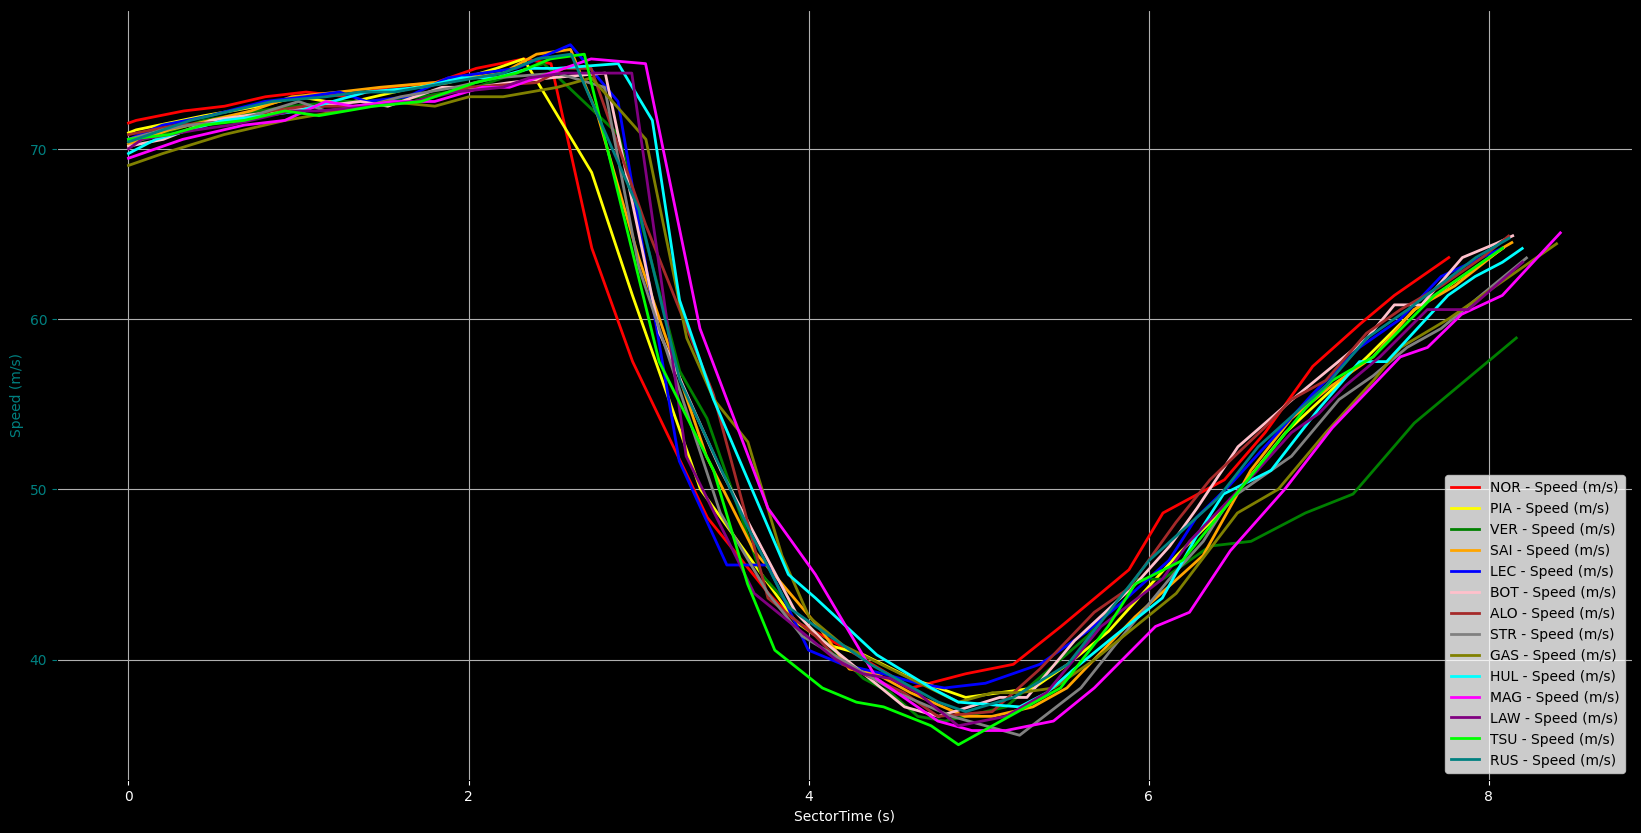

In [52]:
plots.plot_multiple_drivers_telemetry(dfs=[norris_sector3_telemetry_features, piastri_sector3_telemetry_features, verstappen_sector3_telemetry_features, sainz_sector3_telemetry_features, leclerc_sector3_telemetry_features, bottas_sector3_telemetry_features, alonso_sector3_telemetry_features, stroll_sector3_telemetry_features, gasly_sector3_telemetry_features, hulkenberg_sector3_telemetry_features, magnussen_sector3_telemetry_features, lawson_sector3_telemetry_features, tsunoda_sector3_telemetry_features, russell_sector3_telemetry_features],
                                      drivers=[norris, piastri, verstappen, sainz, leclerc, bottas, alonso, stroll, gasly, hulkenberg, magnussen, lawson, tsunoda, russell],
                                      telemetry_cols=[speed])

New engineered features:
1) Steering angle (telemetry data)
2) Initial Brake Timestamp (descriptive statistic)
3) Brake Duration (descriptive statistic)
4) Throttle Ramp Initial Timestamp (descriptive statistic)
5) Throttle Ramp Time (descriptive statistic)

Updated Hypotheses:
1) Faster corner exits translate to greater straight-line speed and reduced lap times.
2) Drivers who re-engage full throttle at the optimal moment after the apex tend to achieve higher corner exit speeds.
3) Drivers who brake precisely at the optimal point maintain greater stability, enabling higher corner exit speeds.
4) Aggressive, late breakers are more likely to lose stability through an apex, leading to slower corner exit speeds.
5) Drivers who apply fewer braking events through a sequence of turns tend to sustain higher RPM levels, resulting in faster corner exit speeds.